# Import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-03-07 10:23:00.018641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 10:23:00.018679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# VAE Model

## Class Sampling

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Encoder

In [12]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(128, 128, 3))

x = layers.Conv2D(8, 4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(8, 4, activation="relu",padding="same")(x)
x = layers.Conv2D(16, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(16, 4, activation="relu", padding="same")(x)
x = layers.Conv2D(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 4, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 2, activation="relu", padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 8)    392         ['input_3[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 8)    1032        ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 16)   2064        ['conv2d_13[0][0]']        

## Decoder

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 64))(x)


x = layers.Conv2DTranspose(64, 2, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(32, 4, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(16, 4, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(8, 4, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(4, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(4, 4, activation="relu", padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              66560     
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 64)         16448     
 ranspose)                                                       
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 64)          16448     
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 32)       32800     
 ranspose)                                                 

## VAE as a model

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Get Data

In [7]:
from icangetyoursmile.utils import get_dataset_tts_from_local

In [9]:
path = "../../raw_data"

X, y, X_test, y_test, X_visu, y_visu = get_dataset_tts_from_local(path, image_size=(128,128), sample_size=1000)

Loading data from ../../raw_data/128x128/...
Done
X shape : (850, 128, 128, 3)
y shape : (850, 128, 128, 3)
X_test shape : (150, 128, 128, 3)
y_test shape : (150, 128, 128, 3)
X_visu shape : (5, 128, 128, 3)
y_visu shape : (5, 128, 128, 3)


In [15]:
y_st = y / 255

In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [21]:
epochs = 400
batch_size = 128

In [22]:
history = vae.fit(y_st, epochs=epochs, batch_size=batch_size)

Epoch 1/400
7/7 [==============================] - 11s 2s/step - loss: 1333.4896 - reconstruction_loss: 1239.7875 - kl_loss: 87.6394
Epoch 2/400
7/7 [==============================] - 11s 2s/step - loss: 1333.3575 - reconstruction_loss: 1240.6139 - kl_loss: 87.8144
Epoch 3/400
7/7 [==============================] - 11s 2s/step - loss: 1322.3744 - reconstruction_loss: 1243.2264 - kl_loss: 87.3381
Epoch 4/400
7/7 [==============================] - 11s 2s/step - loss: 1337.6429 - reconstruction_loss: 1251.7419 - kl_loss: 84.9265
Epoch 5/400
7/7 [==============================] - 11s 2s/step - loss: 1331.6366 - reconstruction_loss: 1239.2107 - kl_loss: 87.3709
Epoch 6/400
7/7 [==============================] - 11s 2s/step - loss: 1317.5943 - reconstruction_loss: 1232.9297 - kl_loss: 86.1980
Epoch 7/400
7/7 [==============================] - 12s 2s/step - loss: 1306.1824 - reconstruction_loss: 1225.1041 - kl_loss: 88.0085
Epoch 8/400
7/7 [==============================] - 11s 2s/step - loss

7/7 [==============================] - 11s 2s/step - loss: 1203.4304 - reconstruction_loss: 1109.2365 - kl_loss: 91.9572
Epoch 63/400
7/7 [==============================] - 11s 2s/step - loss: 1199.4442 - reconstruction_loss: 1110.3367 - kl_loss: 92.4032
Epoch 64/400
7/7 [==============================] - 11s 1s/step - loss: 1207.8445 - reconstruction_loss: 1112.8717 - kl_loss: 90.5261
Epoch 65/400
7/7 [==============================] - 11s 2s/step - loss: 1196.9933 - reconstruction_loss: 1102.1791 - kl_loss: 92.6854
Epoch 66/400
7/7 [==============================] - 11s 2s/step - loss: 1197.3872 - reconstruction_loss: 1099.7820 - kl_loss: 91.8885
Epoch 67/400
7/7 [==============================] - 11s 2s/step - loss: 1194.0971 - reconstruction_loss: 1094.0774 - kl_loss: 92.5936
Epoch 68/400
7/7 [==============================] - 11s 2s/step - loss: 1185.9184 - reconstruction_loss: 1095.2732 - kl_loss: 91.5947
Epoch 69/400
7/7 [==============================] - 11s 2s/step - loss: 119

7/7 [==============================] - 11s 2s/step - loss: 1123.2612 - reconstruction_loss: 1040.1324 - kl_loss: 92.1687
Epoch 124/400
7/7 [==============================] - 11s 2s/step - loss: 1129.4882 - reconstruction_loss: 1038.8495 - kl_loss: 93.2975
Epoch 125/400
7/7 [==============================] - 11s 2s/step - loss: 1127.3787 - reconstruction_loss: 1039.4661 - kl_loss: 93.3958
Epoch 126/400
7/7 [==============================] - 11s 2s/step - loss: 1131.0733 - reconstruction_loss: 1036.5397 - kl_loss: 93.0301
Epoch 127/400
7/7 [==============================] - 11s 2s/step - loss: 1135.8676 - reconstruction_loss: 1044.3812 - kl_loss: 93.3917
Epoch 128/400
7/7 [==============================] - 11s 2s/step - loss: 1129.8203 - reconstruction_loss: 1040.3646 - kl_loss: 94.0409
Epoch 129/400
7/7 [==============================] - 11s 2s/step - loss: 1151.2880 - reconstruction_loss: 1048.3447 - kl_loss: 92.4790
Epoch 130/400
7/7 [==============================] - 11s 2s/step - lo

7/7 [==============================] - 11s 2s/step - loss: 1103.7082 - reconstruction_loss: 1011.1097 - kl_loss: 91.7155
Epoch 184/400
7/7 [==============================] - 11s 2s/step - loss: 1097.3730 - reconstruction_loss: 1000.7538 - kl_loss: 92.6589
Epoch 185/400
7/7 [==============================] - 11s 2s/step - loss: 1101.6102 - reconstruction_loss: 1007.0708 - kl_loss: 93.0980
Epoch 186/400
7/7 [==============================] - 11s 2s/step - loss: 1086.3676 - reconstruction_loss: 1000.5532 - kl_loss: 91.7720
Epoch 187/400
7/7 [==============================] - 11s 2s/step - loss: 1099.9858 - reconstruction_loss: 1016.5887 - kl_loss: 92.5267
Epoch 188/400
7/7 [==============================] - 11s 2s/step - loss: 1086.6248 - reconstruction_loss: 998.2831 - kl_loss: 91.7886
Epoch 189/400
7/7 [==============================] - 11s 2s/step - loss: 1078.6313 - reconstruction_loss: 991.1819 - kl_loss: 93.6833
Epoch 190/400
7/7 [==============================] - 11s 2s/step - loss

7/7 [==============================] - 11s 2s/step - loss: 1083.8015 - reconstruction_loss: 995.6505 - kl_loss: 90.5695
Epoch 245/400
7/7 [==============================] - 11s 2s/step - loss: 1077.3813 - reconstruction_loss: 986.9042 - kl_loss: 91.8789
Epoch 246/400
7/7 [==============================] - 11s 2s/step - loss: 1069.0376 - reconstruction_loss: 969.9730 - kl_loss: 91.8835
Epoch 247/400
7/7 [==============================] - 11s 2s/step - loss: 1056.6065 - reconstruction_loss: 973.7061 - kl_loss: 91.7975
Epoch 248/400
7/7 [==============================] - 11s 2s/step - loss: 1054.2808 - reconstruction_loss: 960.5097 - kl_loss: 92.7272
Epoch 249/400
7/7 [==============================] - 11s 2s/step - loss: 1062.1338 - reconstruction_loss: 968.5704 - kl_loss: 92.4497
Epoch 250/400
7/7 [==============================] - 11s 2s/step - loss: 1056.4284 - reconstruction_loss: 960.6860 - kl_loss: 91.8903
Epoch 251/400
7/7 [==============================] - 11s 2s/step - loss: 104

7/7 [==============================] - 11s 2s/step - loss: 1063.8846 - reconstruction_loss: 977.7553 - kl_loss: 90.6153
Epoch 306/400
7/7 [==============================] - 11s 2s/step - loss: 1049.7249 - reconstruction_loss: 956.1185 - kl_loss: 90.0811
Epoch 307/400
7/7 [==============================] - 11s 2s/step - loss: 1040.5455 - reconstruction_loss: 947.9643 - kl_loss: 92.0688
Epoch 308/400
7/7 [==============================] - 11s 2s/step - loss: 1050.3056 - reconstruction_loss: 962.3104 - kl_loss: 90.2435
Epoch 309/400
7/7 [==============================] - 11s 2s/step - loss: 1042.7320 - reconstruction_loss: 949.4333 - kl_loss: 89.9775
Epoch 310/400
7/7 [==============================] - 11s 2s/step - loss: 1032.1345 - reconstruction_loss: 939.4918 - kl_loss: 92.0321
Epoch 311/400
7/7 [==============================] - 11s 2s/step - loss: 1035.2077 - reconstruction_loss: 940.4603 - kl_loss: 91.3462
Epoch 312/400
7/7 [==============================] - 11s 2s/step - loss: 104

Epoch 366/400
7/7 [==============================] - 6s 791ms/step - loss: 1011.3868 - reconstruction_loss: 918.4474 - kl_loss: 89.8618
Epoch 367/400
7/7 [==============================] - 6s 789ms/step - loss: 1013.9990 - reconstruction_loss: 917.6868 - kl_loss: 90.4644
Epoch 368/400
7/7 [==============================] - 6s 775ms/step - loss: 1008.6792 - reconstruction_loss: 918.3857 - kl_loss: 90.2762
Epoch 369/400
7/7 [==============================] - 5s 777ms/step - loss: 1006.1395 - reconstruction_loss: 919.1223 - kl_loss: 90.1946
Epoch 370/400
7/7 [==============================] - 6s 791ms/step - loss: 1008.0790 - reconstruction_loss: 915.1276 - kl_loss: 90.8562
Epoch 371/400
7/7 [==============================] - 5s 774ms/step - loss: 1015.2212 - reconstruction_loss: 924.2358 - kl_loss: 90.4224
Epoch 372/400
7/7 [==============================] - 5s 775ms/step - loss: 1007.7327 - reconstruction_loss: 924.6024 - kl_loss: 89.6135
Epoch 373/400
7/7 [=============================

In [23]:
loss = history.history["loss"]
r_loss = history.history["reconstruction_loss"]
kl_loss = history.history["kl_loss"]
epoch_range = range(epochs)
epoch_range

range(0, 400)

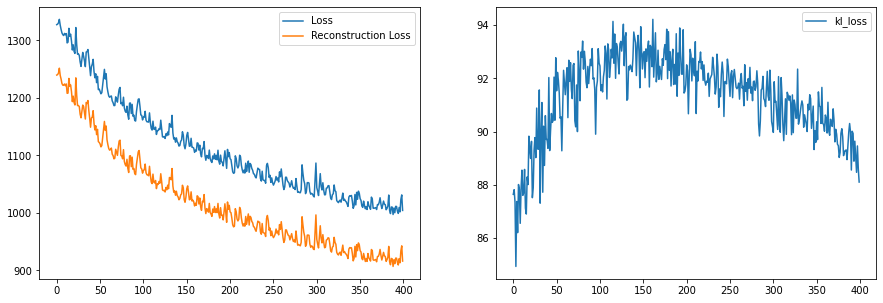

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

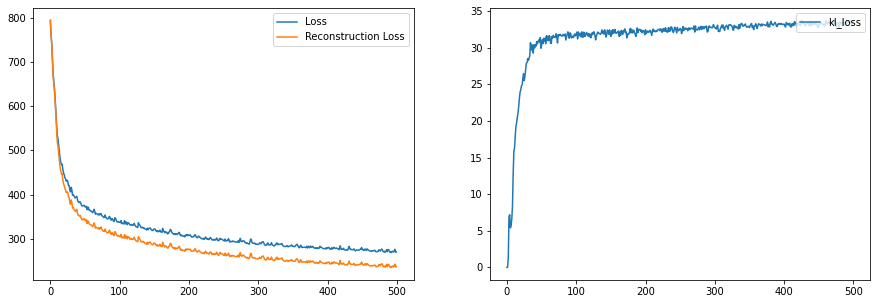

In [41]:
plt.figure(figsize=(15,5))

#Plot Loss & Reconstruction Loss
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Loss")
plt.plot(epoch_range, r_loss, label="Reconstruction Loss")
plt.legend(loc="upper right")

#Plot kl_loss
plt.subplot(1,2,2)
plt.plot(epoch_range, kl_loss, label="kl_loss")
plt.legend(loc="upper right")


plt.show()

In [42]:
import matplotlib.image as mpimg

In [25]:
res = vae.encoder.predict(y_st)

In [26]:
res_f = vae.decoder.predict(res[1])

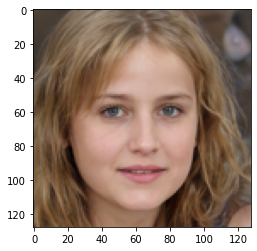

In [27]:
plt.imshow(y[1])

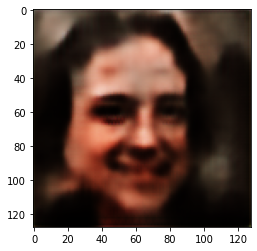

In [28]:
plt.imshow(res_f[1])